## Import libraries

In [1]:
!python -V

Python 3.7.3


In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle

print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)

Numpy version: 1.16.5
Pandas version: 0.24.2


In [3]:
import sklearn as sk
sk.__version__

'0.24.0'

In [4]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

## 1. Import dataset

In [5]:
df = pd.read_excel(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Data\148CA_EN20210701.xlsx')

df.head()

,Gender,Age_value,BMI_value,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,...,Cause_arrest,Hemorrhage_ml,Blood_transfusion_ml,Epinephrine_mg,Atropine_mg,Amiodarone_g,Ephedrine_mg,Methoxamine_mg,CPR_min,Died
0,Female,46.0,23.738662,0,0,0,0,0,0,1,...,Anesthesia,0,0,0.00,0.0,0.00,0.0,0.0,0.16,0
1,Male,72.0,24.341758,0,0,0,0,0,0,0,...,Unknown,1000,650,25.30,0.0,0.30,0.0,0.0,125.00,1
2,Male,56.0,24.034610,0,0,0,0,0,0,0,...,Surgery,150,0,0.03,0.0,0.15,0.0,0.0,21.00,0
3,Female,64.0,29.048656,0,0,0,0,0,0,0,...,Anesthesia,200,0,0.00,0.0,0.00,0.0,0.0,0.50,0
4,Male,68.0,28.081633,0,0,0,0,0,0,0,...,Surgery,0,0,7.50,0.0,0.00,6.0,0.0,180.00,1


In [6]:
pd.DataFrame({"NaN":df.isna().sum(), "datatype":df.dtypes})

,NaN,datatype
Gender,0,object
Age_value,0,float64
BMI_value,0,float64
Comorbidity_diabetes,0,int64
Comorbidity_hypertension,0,int64
Comorbidity_CAD,0,int64
Comorbidity_pulmonary,0,int64
Comorbidity_hepatic,0,int64
Comorbidity_renal,0,int64
Comorbidity_neurological,0,int64


In [7]:
df.loc[df.Age_value <12, 'Died'].value_counts()

1    4
0    3
Name: Died, dtype: int64

In [8]:
df.loc[(df.Age_value >= 12) & (df.Age_value < 40),'Died'].value_counts()

1    17
0    17
Name: Died, dtype: int64

I would combine these 6 children (<12)  and 33 young (12-40) patients together as the children (<12) are in very small number.

In [9]:
df['Age']='<12'
#df['Age']='>=65'
df.loc[(df['Age_value'] >= 12) & (df['Age_value'] < 40), 'Age'] = '12~40'
#df.loc[(df['Age_value'] < 40), 'Age'] = '<40'
df.loc[(df['Age_value'] >= 40) & (df['Age_value'] < 65), 'Age'] = '40~65'
df.loc[(df['Age_value'] >= 65), 'Age'] = '>=65'
#df.loc[(df['Age_value'] <=5), 'Age'] = '<=5'


df['BMI']='Underweight'
df.loc[(df['BMI_value'] >= 19) & (df['BMI_value'] < 24), 'BMI'] = 'Ideal'
df.loc[(df['BMI_value'] >= 24) & (df['BMI_value'] < 28), 'BMI'] = 'Overweight'
df.loc[(df['BMI_value'] >= 28), 'BMI'] = 'Obese'

df['ASA']='I-III'
df.loc[(df['ASA_PS'] >= 4), 'ASA'] = 'IV-V'


#df['Hemorrhage']='0'
df['Hemorrhage'] = '<200'
df.loc[(df['Hemorrhage_ml'] >= 200) & (df['Hemorrhage_ml'] < 800), 'Hemorrhage'] = '200~800'
df.loc[(df['Hemorrhage_ml'] >= 800), 'Hemorrhage'] = '>=800'

#df['Blood_transfusion']='0'
df['Blood_transfusion'] = '<200'
df.loc[(df['Blood_transfusion_ml'] >= 200) & (df['Blood_transfusion_ml'] < 800), 'Blood_transfusion'] = '200~800'
df.loc[(df['Blood_transfusion_ml'] >= 800), 'Blood_transfusion'] = '>=800'

df['Epinephrine']='0'
df.loc[(df['Epinephrine_mg'] > 0) & (df['Epinephrine_mg'] <= 5), 'Epinephrine'] = '<=5'
df.loc[(df['Epinephrine_mg'] > 5), 'Epinephrine'] = '>5'

df['Atropine']='0'
df.loc[(df['Atropine_mg'] > 0) & (df['Atropine_mg'] <= 0.65), 'Atropine'] = '<=0.65'
df.loc[(df['Atropine_mg'] > 0.65), 'Atropine'] = '>0.65'

df['Amiodarone']='0'
#df.loc[(df['Amiodarone_g'] > 0) & (df['Amiodarone_g'] <= 0.11), 'Amiodarone'] = '<=0.11'
df.loc[(df['Amiodarone_g'] > 0), 'Amiodarone'] = '0.04~0.3'
        
df['Ephedrine']='0'
#df.loc[(df['Ephedrine_mg'] > 0) & (df['Ephedrine_mg'] <= 6), 'Ephedrine'] = '<=6'
df.loc[(df['Ephedrine_mg'] > 0), 'Ephedrine'] = '6~15'
        
df['Methoxamine']='0'
#df.loc[(df['Methoxamine_mg'] > 0) & (df['Methoxamine_mg'] <= 3), 'Methoxamine'] = '<=3'
df.loc[(df['Methoxamine_mg'] > 0), 'Methoxamine'] = '1~35'
   
#df['CPR']='0'
#df.loc[(df['CPR_min'] > 0) & (df['CPR_min'] < 30), 'CPR'] = '<=30'
df.loc[(df['CPR_min'] < 30), 'CPR'] = '<30'
df.loc[(df['CPR_min'] >= 30) & (df['CPR_min'] < 60), 'CPR'] = '30~60'
df.loc[(df['CPR_min'] >= 60), 'CPR'] = '>=60'


df2=df[["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR","Died"]]


df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 29 columns):
Gender                      149 non-null object
Age                         149 non-null object
BMI                         149 non-null object
Comorbidity_diabetes        149 non-null int64
Comorbidity_hypertension    149 non-null int64
Comorbidity_CAD             149 non-null int64
Comorbidity_pulmonary       149 non-null int64
Comorbidity_hepatic         149 non-null int64
Comorbidity_renal           149 non-null int64
Comorbidity_neurological    149 non-null int64
Comorbidity_tumor           149 non-null int64
Surgical_type               149 non-null object
Emergency                   149 non-null int64
Trauma                      149 non-null int64
Anaesthetic_type            149 non-null object
Operative_position          149 non-null object
ASA                         149 non-null object
Timing_arrest               149 non-null object
Defibrillate                149 non-null 

In [10]:
df=df2

## 2. Split into trainning and test set
Before doing any EDA on the data, it is best practice to split the data into trainning and test set, and only explore on the trainning set.  

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [132]:
#Now split the data into training and test set(85-15 split)
data_train, data_test = train_test_split(df, test_size=.25,
                                         stratify=df.Gender, random_state=42)

In [133]:
#Let's check to make sure the output variable is correctly stratified across train/test sets              
#stratify=df.died_hosp, random_state=42)
pd.DataFrame({
    'original': df.Gender.value_counts() / len(df),
    'train': data_train.Gender.value_counts() / len(data_train),
    'test': data_test.Gender.value_counts() / len(data_test)})[['original', 'train', 'test']]  

,original,train,test
Male,0.637584,0.63964,0.631579
Female,0.362416,0.36036,0.368421


In [134]:
pd.DataFrame({
    'original': df.Died.value_counts() / len(df),
    'train': data_train.Died.value_counts() / len(data_train),
    'test': data_test.Died.value_counts() / len(data_test)})[['original', 'train', 'test']]         

,original,train,test
0,0.456376,0.423423,0.552632
1,0.543624,0.576577,0.447368


In [135]:
pd.DataFrame({
    'original': df.Age.value_counts() / len(df),
    'train': data_train.Age.value_counts() / len(data_train),
    'test': data_test.Age.value_counts() / len(data_test)})[['original', 'train', 'test']]  

,original,train,test
40~65,0.536913,0.531532,0.552632
12~40,0.228188,0.225225,0.236842
>=65,0.187919,0.198198,0.157895
<12,0.046980,0.045045,0.052632


In [136]:
len(data_train), len(data_test), len(data_test)/len(df)

(111, 38, 0.2550335570469799)

In [137]:
#So the class label is split preserving the class proportions and is in 90-10 ratio   
print(data_train.shape)
print(data_test.shape)

(111, 29)
(38, 29)


In [138]:
data_train.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,...,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR,Died
81,Female,12~40,Ideal,0,0,0,1,1,0,0,...,Anesthesia,<200,<200,<=5,0,0,0,0,<30,0
119,Female,>=65,Ideal,0,0,1,0,0,1,1,...,Comorbidity,<200,<200,<=5,<=0.65,0,0,0,<30,0
103,Female,12~40,Obese,0,0,1,1,0,0,0,...,Comorbidity,200~800,<200,>5,0,0,0,0,30~60,1
129,Male,40~65,Overweight,0,0,0,0,1,0,1,...,Surgery,<200,<200,0,0,0.04~0.3,6~15,1~35,<30,0
31,Male,>=65,Ideal,0,0,0,1,0,1,0,...,Anesthesia,<200,<200,0,<=0.65,0,6~15,0,<30,1


In [23]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111 entries, 81 to 29
Data columns (total 29 columns):
Gender                      111 non-null object
Age                         111 non-null object
BMI                         111 non-null object
Comorbidity_diabetes        111 non-null int64
Comorbidity_hypertension    111 non-null int64
Comorbidity_CAD             111 non-null int64
Comorbidity_pulmonary       111 non-null int64
Comorbidity_hepatic         111 non-null int64
Comorbidity_renal           111 non-null int64
Comorbidity_neurological    111 non-null int64
Comorbidity_tumor           111 non-null int64
Surgical_type               111 non-null object
Emergency                   111 non-null int64
Trauma                      111 non-null int64
Anaesthetic_type            111 non-null object
Operative_position          111 non-null object
ASA                         111 non-null object
Timing_arrest               111 non-null object
Defibrillate                111 non-null 

## 3. Exploratory Data Analysis on training set

"Heart Disease data" is obtained by "pandas_profiling", visuaizing the exploratory analysis of the data.

**WARNING:** The code below can take **a couple of minutes** to finish

In [273]:
import pandas_profiling
pandas_profiling.ProfileReport(data_train)

AbstractMethodError: This method must be defined in the concrete class type

## 4. Data preprocessing pipelines
Prepare the data to a format that can be fit into scikit learn algorithms

**Categorical variable encoder**

https://stackoverflow.com/questions/36631163/what-are-the-pros-and-cons-between-get-dummies-pandas-and-onehotencoder-sciki
https://masongallo.github.io/machine/learning,/python/2017/10/07/machine-learning-pipelines.html

In [24]:
categorical_vars = ["Gender","Age","BMI","Comorbidity_diabetes","Comorbidity_hypertension","Comorbidity_CAD",
"Comorbidity_pulmonary","Comorbidity_hepatic","Comorbidity_renal","Comorbidity_neurological",
"Comorbidity_tumor","Surgical_type","Emergency","Trauma","Anaesthetic_type","Operative_position",
"ASA","Timing_arrest","Defibrillate","Cause_arrest","Hemorrhage","Blood_transfusion",
"Epinephrine","Atropine","Amiodarone","Ephedrine","Methoxamine","CPR"]

In [25]:
data_train[categorical_vars].head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,...,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
81,Female,12~40,Ideal,0,0,0,1,1,0,0,...,0,Anesthesia,<200,<200,<=5,0,0,0,0,<30
119,Female,>=65,Ideal,0,0,1,0,0,1,1,...,1,Comorbidity,<200,<200,<=5,<=0.65,0,0,0,<30
103,Female,12~40,Obese,0,0,1,1,0,0,0,...,1,Comorbidity,200~800,<200,>5,0,0,0,0,30~60
129,Male,40~65,Overweight,0,0,0,0,1,0,1,...,1,Surgery,<200,<200,0,0,0.04~0.3,6~15,1~35,<30
31,Male,>=65,Ideal,0,0,0,1,0,1,0,...,0,Anesthesia,<200,<200,0,<=0.65,0,6~15,0,<30


In [26]:
# to make a custom transformer to fit into a pipeline
class Vars_selector(BaseEstimator, TransformerMixin):
    '''Returns a subset of variables in a dataframe'''
    def __init__(self, var_names):
        '''var_names is a list of categorical variables names'''
        self.var_names = var_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''returns a dataframe with selected variables'''
        return X[self.var_names]

In [27]:
class Cat_vars_encoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''X is a dataframe'''
        X['Gender'] = X.Gender.map({'Male':1, 'Female':0}) # M -> 1, F -> 0
        #X['Age'] = X.Age.map({'<40':0,'40~65':1,'>=65':2}) # 
        X['Age'] = X.Age.map({'<12':0,'12~40':1,'40~65':2,'>=65':3}) # 
        X['BMI'] = X.BMI.map({'Underweight':0, 'Ideal':1,'Overweight':2,'Obese':3}) # 
        X['ASA'] = X.ASA.map({'I-III':0, 'IV-V':1}) # 
        X['Hemorrhage'] = X.Hemorrhage.map({'<200':0, '200~800':1,'>=800':2}) # 
        X['Blood_transfusion'] = X.Blood_transfusion.map({'<200':0, '200~800':1,'>=800':2}) # 
        X['Epinephrine'] = X.Epinephrine.map({'0':0, '<=5':1,'>5':2}) # 
        X['Atropine'] = X.Atropine.map({'0':0, '<=0.65':1,'>0.65':2}) # 
        X['Amiodarone'] = X.Amiodarone.map({'0':0, '0.04~0.3':1}) # 
        X['Ephedrine'] = X.Ephedrine.map({'0':0, '6~15':1}) # 
        X['Methoxamine'] = X.Methoxamine.map({'0':0, '1~35':1}) # 
        X['CPR'] = X.CPR.map({'<30':0,'30~60':1,'>=60':2}) # 
        X['Surgical_type'] = X.Surgical_type.map({'Abdominal':0, 'Neurosurgery':1,'Thoracic':2,'Throat':3,'Others':4}) 
        # Abdominal->0, Neurosurgery->1,Thoracic->3,Throat->4,Others->5'Orthopedics':2,
        X['Anaesthetic_type'] = X.Anaesthetic_type.map({'General':1, 'Local':0}) # General -> 1, Local -> 0
        X['Operative_position'] = X.Operative_position.map({'Left lateral decubitus':0, 'Right lateral decubitus':1,'Prone':2,
                                                           'Lithotomy':3,'Supine':4}) # 
        X['Timing_arrest'] = X.Timing_arrest.map({'Induction':0, 'Intubation':1,'Surgery':2,'NotAvaliable':3}) #
        X['Cause_arrest'] = X.Cause_arrest.map({'Anesthesia':0, 'Comorbidity':1,'Surgery':2,'Unknown':3}) # M -> 1, F -> 0
        return X.values

**Transform data in a pipeline** 

In [28]:
# categorical variables preprocessing
cat_vars_pipeline = Pipeline([
    ('selector', Vars_selector(categorical_vars)),
    ('encoder', Cat_vars_encoder())
])

For many machine learning algorithms, gradient descent is the preferred or even the only optimization method to learn the model parameters. Gradient descent is highly sensitive to feature scaling.

** Continuous vars **

In [29]:
continuous_vars = [] #['Age', 'BMI', 'Hemorrhage_ml', 'Blood_transfusion', 'Epinephrine_mg', 'Atropine_mg',
       #'Amiodarone_g', 'Ephedrine_mg', 'Methoxamine_mg', 'CPR_min']

In [30]:
#data_train[continuous_vars].describe()

The scales among the continuous variables vary a lot, we need to standardize them prior to modelling.

In [31]:
## continuous variables preprocessing
#cont_vars_pipeline = Pipeline([
   # ('selector', Vars_selector(continuous_vars)),
    #('standardizer', StandardScaler())
#])


To transform the two types of variables in one step

In [32]:
preproc_pipeline = FeatureUnion(transformer_list=[
    ('cat_pipeline', cat_vars_pipeline)
    #,('cont_pipeline', cont_vars_pipeline)
])

In [33]:
#data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            #columns=categorical_vars + continuous_vars)

In [34]:
data_train_X = pd.DataFrame(preproc_pipeline.fit_transform(data_train), 
                            columns=categorical_vars + continuous_vars)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [35]:
data_train_X.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,...,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
0,0,1,1,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,3,1,0,0,1,0,0,1,1,...,1,1,0,0,1,1,0,0,0,0
2,0,1,3,0,0,1,1,0,0,0,...,1,1,1,0,2,0,0,0,0,1
3,1,2,2,0,0,0,0,1,0,1,...,1,2,0,0,0,0,1,1,1,0
4,1,3,1,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0



## 5. Fitting a classifier and fine-tuning

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import learning_curve, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

In [37]:
data_train['Died'].value_counts()

1    64
0    47
Name: Died, dtype: int64

This is a fairly balanced dataset(i.e., the number of positive and negative cases are roughly the same), and we'll use AUC as our metric to optimise the model performance.


**_Assessing learning curve using the model default settings_**  
Tuning the model hyper-parameters are always difficult, so a good starting point is to see how the Scikit-learn default settings for the model performs, i.e., to see if it overfits or underfits, or is just right. This will give a good indication as to the direction of tuning. 

In [38]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv=5, scoring='roc_auc',
                                                           random_state=42, n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), "o-", label="training scores")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), "o-", label="x-val scores")
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.xlabel("Training set size")
    plt.ylabel("Area under Curve")
    plt.title('{} learning curve'.format(model.__class__.__name__))


### Logistic Regression
Our first model is logistic regression

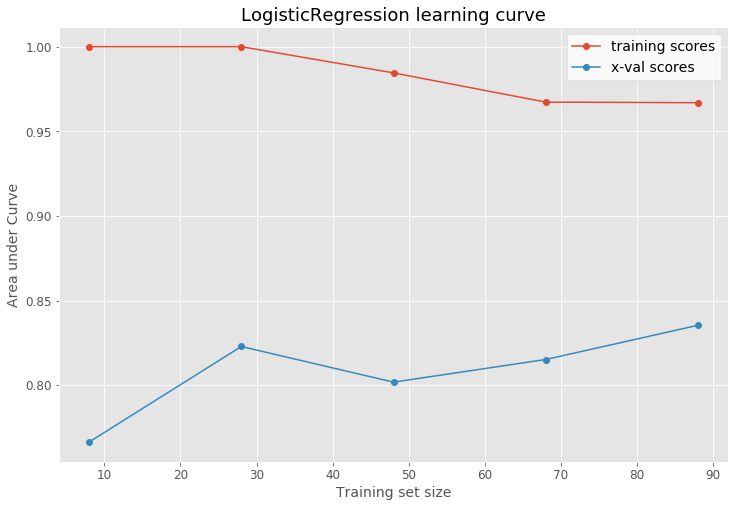

In [39]:
lr_clf = LogisticRegression(n_jobs = -1)
plot_learning_curves(lr_clf, data_train_X, data_train['Died'])

Let's see if we can squeeze some more performance out by optimising C.

In [40]:
param_grid = {
        'C': [0.01, 0.1, 1, 10, 100, 1000],
    }
lr_clf = LogisticRegression(random_state=42)
grid_search = GridSearchCV(lr_clf, param_grid=param_grid, return_train_score=True,
                                cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(data_train_X, data_train['Died'])


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc')

In [41]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

,X-val scores,Train scores,Params
0,0.837137,0.966426,{'C': 1}
1,0.832521,0.942298,{'C': 0.1}
2,0.811239,0.980055,{'C': 10}
3,0.806838,0.895397,{'C': 0.01}
4,0.778590,0.987245,{'C': 100}
5,0.758590,0.991538,{'C': 1000}


Looks like C=0.1 is our best value.

In [42]:
lr_clf = grid_search.best_estimator_
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\lr_clf_final_round.pk1', 'wb') as f:
    pickle.dump(lr_clf, f)

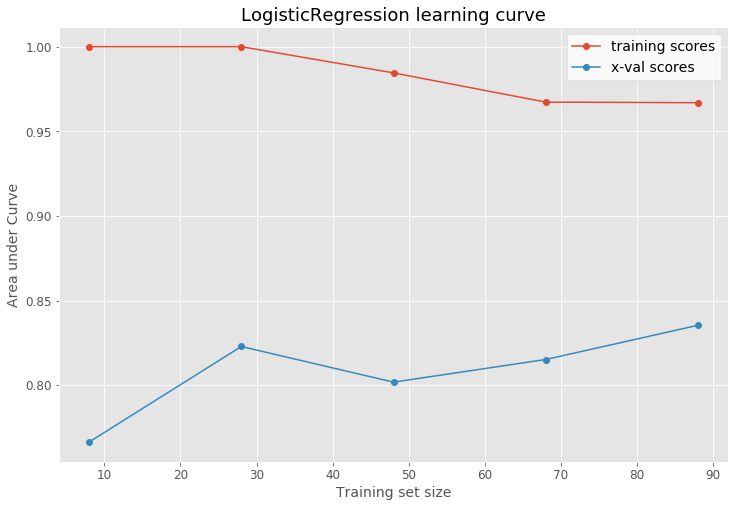

In [43]:
plot_learning_curves(lr_clf, data_train_X, data_train['Died'])

Looks like the logistic regression model would benefit from additional data.

### Random Forests classifier
Random forests classifier is an ensemble tree-based model that reduces the variance of the predictors.

_plot the learning curve to find out where the default model is at_

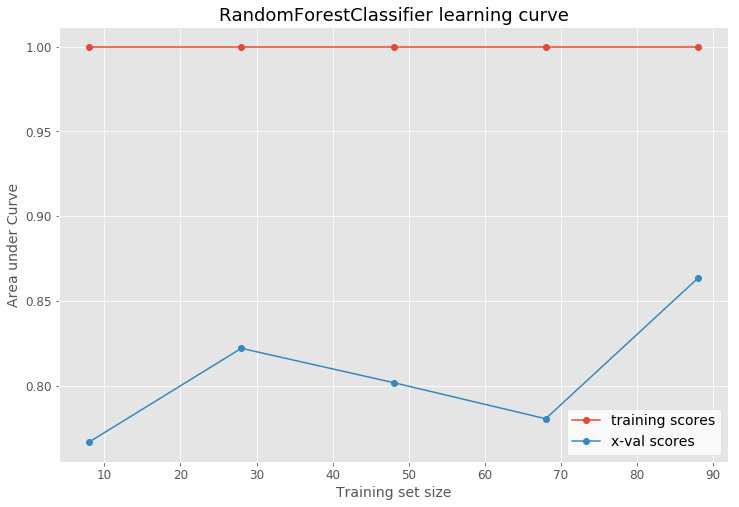

In [44]:
rf_clf = RandomForestClassifier(random_state=42)
plot_learning_curves(rf_clf, data_train_X, data_train['Died'])

The default Random Forests classifier needs to be constrained. We'll use a randomised search to optimise hyperparameters

In [45]:
param_distribs = {
        'n_estimators': stats.randint(low=1, high=50),
         'max_features': ['auto', 'log2'],
        'max_depth': stats.randint(low=2, high=100),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rf_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(rf_clf, param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
rnd_search.fit(data_train_X, data_train['Died'])

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7EE203CF8>,
                                        'max_features': ['auto', 'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7EE203FD0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7EE203438>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7EE203D68>},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [46]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

,X-val scores,Train scores,Params
0,0.836603,0.877709,"{'max_depth': 24, 'max_features': 'auto', 'min..."
1,0.833803,0.840843,"{'max_depth': 9, 'max_features': 'log2', 'min_..."
2,0.832927,0.849164,"{'max_depth': 91, 'max_features': 'auto', 'min..."
3,0.831090,0.850344,"{'max_depth': 62, 'max_features': 'log2', 'min..."
4,0.829850,0.864221,"{'max_depth': 65, 'max_features': 'auto', 'min..."
5,0.822970,0.871309,"{'max_depth': 8, 'max_features': 'auto', 'min_..."
6,0.822521,0.933765,"{'max_depth': 95, 'max_features': 'log2', 'min..."
7,0.817115,0.862061,"{'max_depth': 57, 'max_features': 'auto', 'min..."
8,0.811368,0.917691,"{'max_depth': 37, 'max_features': 'log2', 'min..."
9,0.807222,0.985457,"{'max_depth': 61, 'max_features': 'auto', 'min..."


As suspected, the best parameters have set constraints on the depth of the tree, mininum samples on the split nodes and leaf nodes.

In [47]:
rf_clf = rnd_search.best_estimator_
rf_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'wb') as f:
    pickle.dump(rf_clf, f)

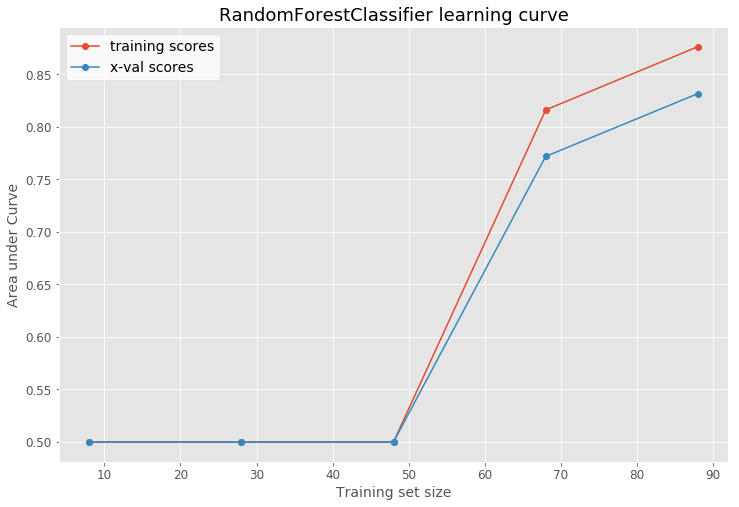

In [48]:
plot_learning_curves(rf_clf, data_train_X, data_train['Died'])

The learning curve of the best Random Forests model suggests that the performance of the model might continue to increase with more traning data.

### Gradient boosting classifier
Gradient boosting classifier is an ensemble tree-based model that reduces the bias of the predictors.

_plot the learning curve to find out where the default model is at_

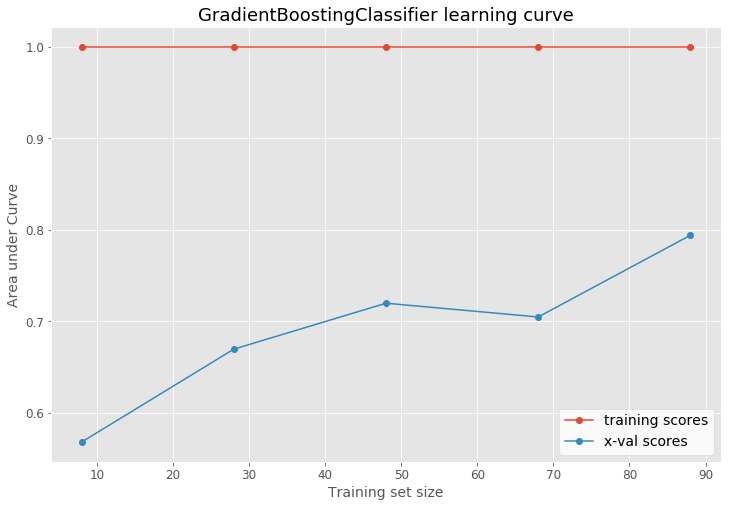

In [49]:
plot_learning_curves(GradientBoostingClassifier(random_state=42), data_train_X, data_train['Died'])

The learning curve of the GBM might be a little underfitting. Maybe reducing regularization of the model could lead to better performance. We'll use a randomised search to optimise hyperparameters.

In [50]:
param_distribs = {
        'n_estimators': stats.randint(low=80, high=200),
        'max_depth': stats.randint(low=3, high=50),
        'min_samples_split': stats.randint(low=2, high=100), 
        'min_samples_leaf': stats.randint(low=2, high=100),
    }
rnd_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), 
                                param_distributions=param_distribs, return_train_score=True,
                                n_iter=100, cv=5, scoring='roc_auc', random_state=42, n_jobs=-1)
# this will take a long time
rnd_search.fit(data_train_X, data_train['Died'])

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7F0F47BE0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7F0F20DA0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7F0F200B8>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000D7F0EF9CF8>},
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [51]:
cv_rlt = rnd_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

,X-val scores,Train scores,Params
0,0.855214,0.994929,"{'max_depth': 15, 'min_samples_leaf': 4, 'min_..."
1,0.854915,0.991586,"{'max_depth': 29, 'min_samples_leaf': 10, 'min..."
2,0.849829,0.982645,"{'max_depth': 10, 'min_samples_leaf': 8, 'min_..."
3,0.849145,0.999794,"{'max_depth': 21, 'min_samples_leaf': 3, 'min_..."
4,0.844444,1.000000,"{'max_depth': 44, 'min_samples_leaf': 5, 'min_..."
5,0.842906,0.998755,"{'max_depth': 46, 'min_samples_leaf': 9, 'min_..."
6,0.841752,1.000000,"{'max_depth': 42, 'min_samples_leaf': 5, 'min_..."
7,0.832009,0.927212,"{'max_depth': 35, 'min_samples_leaf': 25, 'min..."
8,0.826581,0.978932,"{'max_depth': 11, 'min_samples_leaf': 20, 'min..."
9,0.823846,0.903271,"{'max_depth': 16, 'min_samples_leaf': 28, 'min..."


We'll save the best model, retrain it on the whole dataset and save the model

In [52]:
gbm_clf = rnd_search.best_estimator_
gbm_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\gbm_clf_final_round.pk1', 'wb') as f:
    pickle.dump(gbm_clf, f)

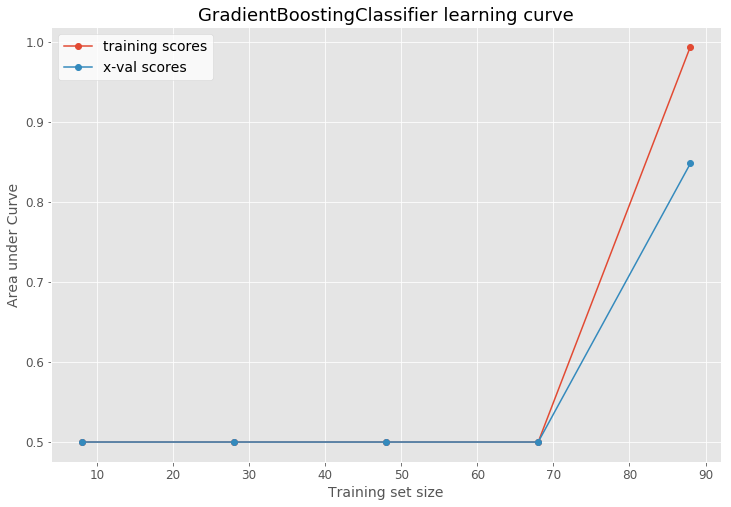

In [53]:
plot_learning_curves(gbm_clf, data_train_X, data_train['Died'])

The learning curve of the best Gradient Boosting model suggests that the performance of the model dramatically improves with more 30 traning data.

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

_plot the learning curve to find out where the default model is at_

Try Linear SVC fist

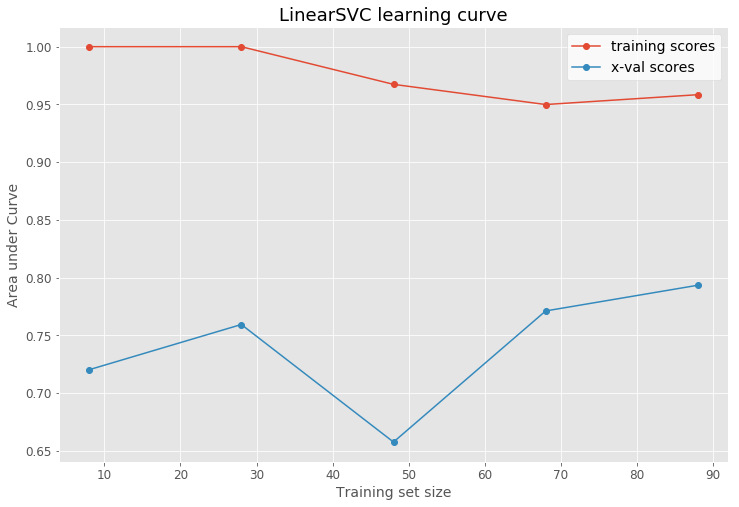

In [54]:
plot_learning_curves(LinearSVC(loss='hinge', random_state=42), data_train_X, data_train['Died'])

Try Polynomial kernel

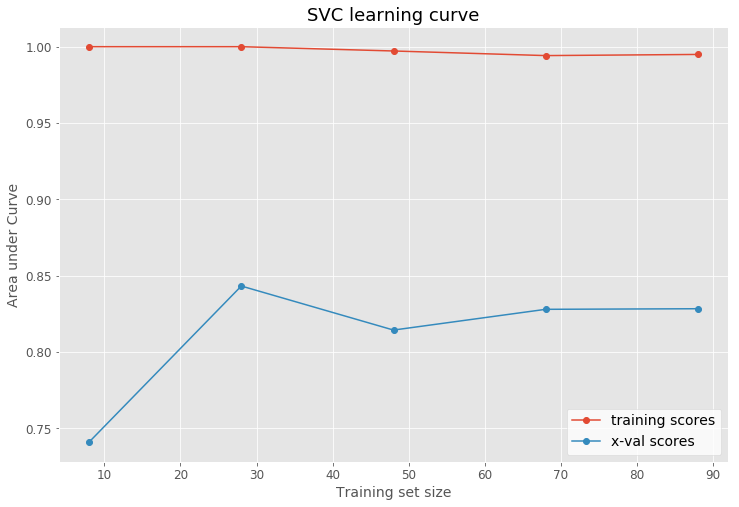

In [55]:
plot_learning_curves(SVC(kernel='poly', random_state=42), data_train_X, data_train['Died'])

Try Gaussian RBF kernel

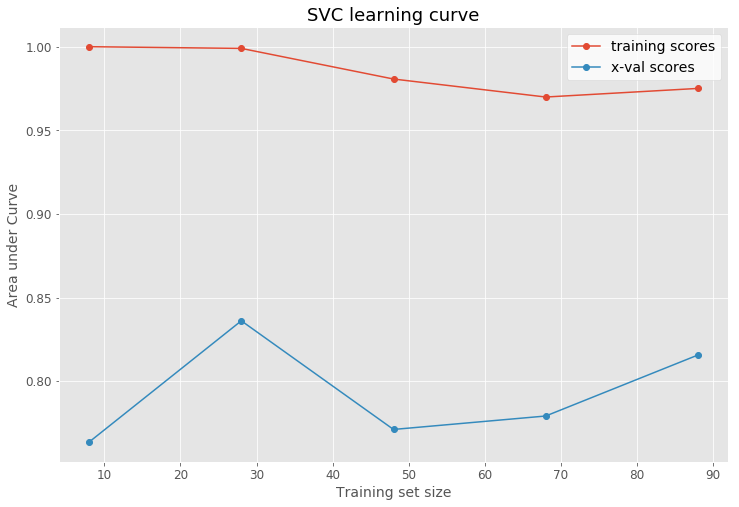

In [56]:
plot_learning_curves(SVC(kernel='rbf',random_state=42), data_train_X, data_train['Died'])

The Polynomial SVC shows that the default settings resulting in underfitted model, however, the performance is likely to improve if the complexity of the model increases, e.g., use higher degree polynomials.  

The default settings for RBF SVC performs the best, and with a gap between the training and validation accuracies, it is likely to improve the performance by regularization.

In [57]:
rbf_gamma = [1/len(data_train_X.columns) * x for x in range(1, 15, 5)] #range(1, 20, 5)]
param_grid = [
    # first try Poly kernel
    ## coef0 hyper-parameter was also tested originally, however, it is taking too long
    {'kernel':['poly'], 'degree': [3, 9, 15], 'C': [1, 10, 100]},
    # then try RBF kernel
    {'gamma': rbf_gamma, 'C': [1, 10, 100]},
  ]

grid_search = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5,
                           scoring='roc_auc', n_jobs=-1)

# this will take a long time
grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100], 'degree': [3, 9, 15],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100],
                          'gamma': [0.03571428571428571, 0.21428571428571427,
                                    0.39285714285714285]}],
             scoring='roc_auc')

In [58]:
cv_rlt = grid_search.cv_results_
#pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['std_test_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

,X-val scores,Train scores,Params
0,0.834530,0.114202,"{'C': 10, 'degree': 3, 'kernel': 'poly'}"
1,0.834530,0.114202,"{'C': 100, 'degree': 3, 'kernel': 'poly'}"
2,0.830043,0.090012,"{'C': 1, 'degree': 3, 'kernel': 'poly'}"
3,0.818205,0.109158,"{'C': 10, 'gamma': 0.03571428571428571}"
4,0.816496,0.111689,"{'C': 100, 'gamma': 0.03571428571428571}"
5,0.812308,0.119922,"{'C': 1, 'gamma': 0.03571428571428571}"
6,0.794530,0.103323,"{'C': 10, 'degree': 9, 'kernel': 'poly'}"
7,0.794530,0.103323,"{'C': 100, 'degree': 9, 'kernel': 'poly'}"
8,0.787692,0.112039,"{'C': 1, 'degree': 9, 'kernel': 'poly'}"
9,0.781667,0.135541,"{'C': 1, 'gamma': 0.21428571428571427}"


SVM training is very computationaly expensive, making it not scalable to big data sets. As it turns out the default RBF SVM results the best cross-validation score.

In [59]:
svc_clf = grid_search.best_estimator_
svc_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\svc_clf_final_round.pkl', 'wb') as f:
    pickle.dump(svc_clf, f)

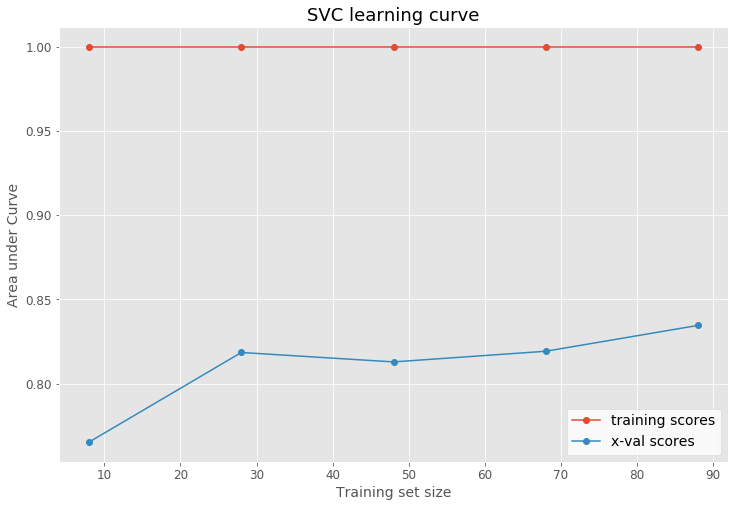

In [60]:
# best model is the default RBF kernal SVM
plot_learning_curves(svc_clf, data_train_X, data_train['Died']) 

### AdaBoostClassifier classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

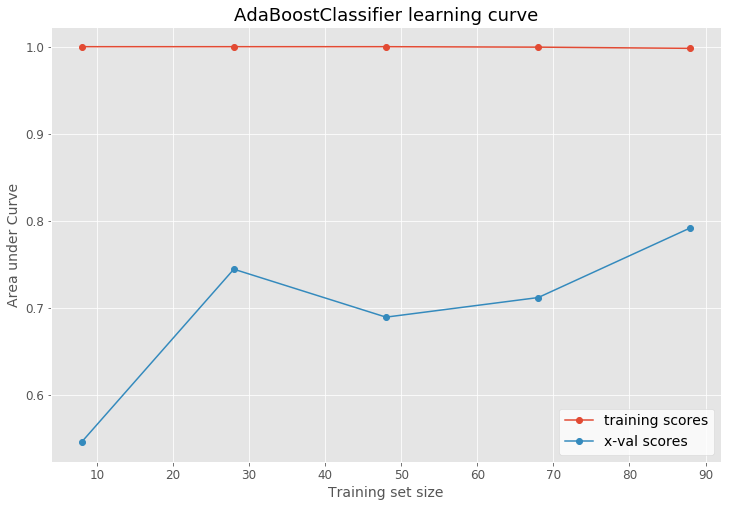

In [61]:
from sklearn.ensemble import AdaBoostClassifier

adab_clf = AdaBoostClassifier()
plot_learning_curves(adab_clf, data_train_X, data_train['Died'])

In [62]:
param_grid = {'n_estimators': [1,5,10,50],
        'learning_rate': [0.001,0.01,0.1,0.2,1] }
adab_clf = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(adab_clf, param_grid=param_grid, return_train_score=True,
                           cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(data_train_X, data_train['Died'])

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 1],
                         'n_estimators': [1, 5, 10, 50]},
             return_train_score=True, scoring='roc_auc')

In [63]:
cv_rlt = grid_search.cv_results_
pd.DataFrame(sorted(list(zip(cv_rlt["mean_test_score"], cv_rlt['mean_train_score'], cv_rlt["params"])), 
                    key=lambda x: x[0], reverse=True), columns=['X-val scores', 'Train scores', 'Params'])

,X-val scores,Train scores,Params
0,0.830812,0.961288,"{'learning_rate': 1, 'n_estimators': 10}"
1,0.791966,0.997935,"{'learning_rate': 1, 'n_estimators': 50}"
2,0.789402,0.893335,"{'learning_rate': 0.2, 'n_estimators': 10}"
3,0.772415,0.854947,"{'learning_rate': 0.2, 'n_estimators': 5}"
4,0.769850,0.838533,"{'learning_rate': 0.1, 'n_estimators': 5}"
5,0.764444,0.947466,"{'learning_rate': 0.1, 'n_estimators': 50}"
6,0.756795,0.971150,"{'learning_rate': 0.2, 'n_estimators': 50}"
7,0.754295,0.849985,"{'learning_rate': 0.01, 'n_estimators': 50}"
8,0.751902,0.855271,"{'learning_rate': 0.1, 'n_estimators': 10}"
9,0.740171,0.899340,"{'learning_rate': 1, 'n_estimators': 5}"


In [64]:
adab_clf = grid_search.best_estimator_
adab_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\adab_clf_final_round.pk1', 'wb') as f:
    pickle.dump(adab_clf, f)

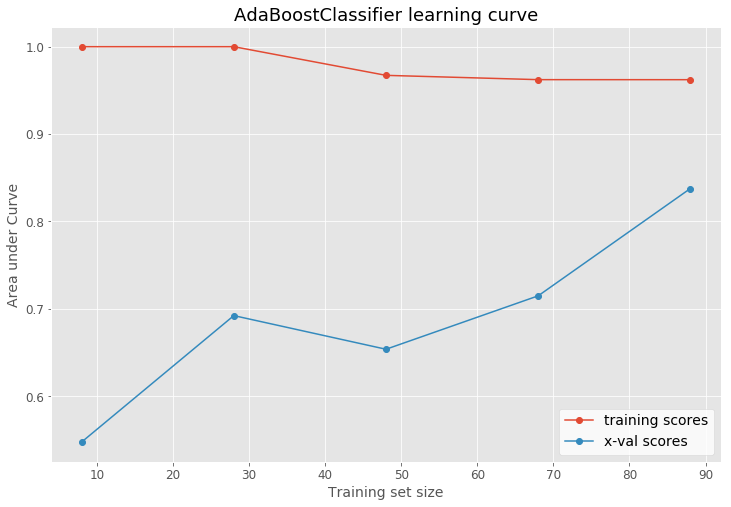

In [65]:
plot_learning_curves(adab_clf, data_train_X, data_train['Died'])

### Support vector machine classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

### Ensemble classifier
Scikit-learn offers a voting classifier which aggregates the prediction of multiple predictors and is a flexible ensemble technique that allows an ensemble of different models.  
For the final classifier, simply aggregate the predictions of the three best models, i.e., logistic regression,random forests, gradien boosting machine and the support vector machine.
https://www.kaggle.com/rafjaa/dealing-with-very-small-datasets

In [66]:
#ensemble_clf = VotingClassifier(estimators=[('rf', rf_clf), ('gbm', gbm_clf), ('svc', svc_clf)],
ensemble_clf = VotingClassifier(estimators=[('lr', lr_clf), ('rf', rf_clf), ('gbm', gbm_clf), ('svc', svc_clf), ('adab', adab_clf)],
                             voting='soft')
ensemble_clf.fit(data_train_X, data_train['Died'])

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=24,
                                                     min_samples_leaf=16,
                                                     min_samples_split=44,
                                                     n_estimators=29,
                                                     random_state=42)),
                             ('gbm',
                              GradientBoostingClassifier(max_depth=15,
                                                         min_samples_leaf=4,
                                                         min_samples_split=71,
                                                         n_estimators=151,
                                                         random_state=42)),
                             ('svc',
                              SVC(C=10, kernel='poly', probability=True,
  

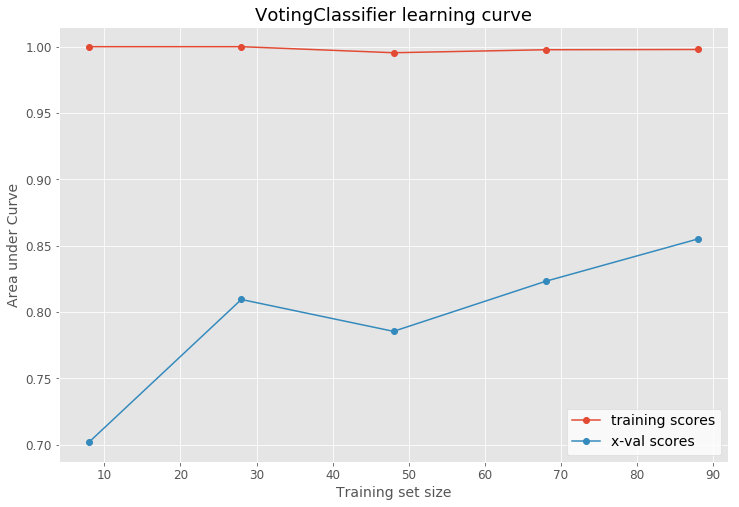

In [67]:
plot_learning_curves(ensemble_clf, data_train_X, data_train['Died'])

In [68]:
#ensemble_clf = grid_search.best_estimator_
ensemble_clf.fit(data_train_X, data_train['Died'])
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'wb') as f:
    pickle.dump(ensemble_clf, f)

## 6. Compute and compare test metrics

**Transform test data set**

In [69]:
data_test_X = pd.DataFrame(preproc_pipeline.transform(data_test), # it's imperative not to do fit_transfomr again
                           columns=categorical_vars + continuous_vars)
#columns=categorical_vars + numerical_vars)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [70]:
data_test_X.shape

(38, 28)

In [71]:
data_test_X.head()

,Gender,Age,BMI,Comorbidity_diabetes,Comorbidity_hypertension,Comorbidity_CAD,Comorbidity_pulmonary,Comorbidity_hepatic,Comorbidity_renal,Comorbidity_neurological,...,Defibrillate,Cause_arrest,Hemorrhage,Blood_transfusion,Epinephrine,Atropine,Amiodarone,Ephedrine,Methoxamine,CPR
0,0,1,3,0,0,0,0,0,0,0,...,1,1,2,2,1,0,0,0,0,0
1,1,2,3,0,0,0,0,0,0,0,...,0,0,1,0,1,1,0,1,0,0
2,0,2,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
3,0,1,2,0,0,0,0,0,1,0,...,0,3,2,2,1,1,0,0,0,0
4,0,2,1,0,0,0,0,1,0,1,...,1,3,0,0,2,0,0,0,0,2


**Compute test accuracy score**

In [72]:
def plot_roc_curve(fpr, tpr, auc, model=None):
    if model == None:
        title = None
    elif isinstance(model, str):
        title = model
    else:
        title = model.__class__.__name__
#    title = None if model == None else model.__class__.__name__
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linewidth=2, label='auc: {}'.format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1.01, -.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.legend(fontsize=14).get_frame().set_facecolor('white')
    plt.title('{} - ROC Curve'.format(title))

### _Logistic Regression model_

In [73]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\lr_clf_final_round.pk1', 'rb') as f:
    lr_clf = pickle.load(f)
lr_clf.fit(data_train_X, data_train['Died'])

LogisticRegression(C=1, random_state=42)

Accuracy scores

In [74]:
accu_lr = accuracy_score(data_test['Died'], lr_clf.predict(data_test_X))

In [75]:
accu_lr

0.7894736842105263

In [76]:
pd.crosstab(data_test['Died'], lr_clf.predict(data_test_X))

col_0,0,1
Died,,
0,16,5
1,3,14


ROC and AUC

In [77]:
pred_proba_lr = lr_clf.predict_proba(data_test_X)

In [78]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_lr[:, 1])
auc_lr = roc_auc_score(data_test['Died'], pred_proba_lr[:, 1])

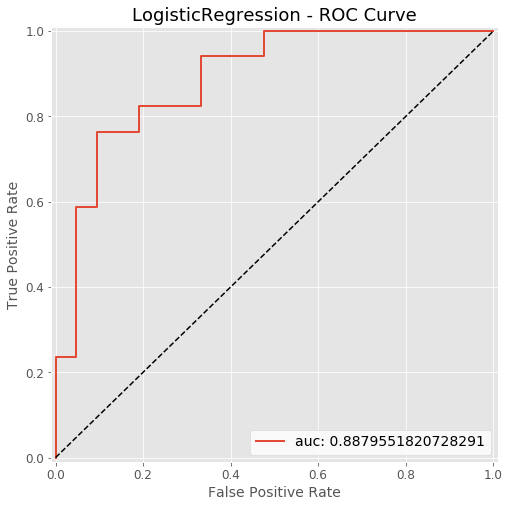

In [79]:
plot_roc_curve(fpr, tpr, auc_lr, lr_clf)

### _Random forests model_

In [80]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\rf_clf_final_round.pk1', 'rb') as f:
    rf_clf = pickle.load(f)
rf_clf.fit(data_train_X, data_train['Died'])

RandomForestClassifier(max_depth=24, min_samples_leaf=16, min_samples_split=44,
                       n_estimators=29, random_state=42)

Accuracy scores

In [81]:
accu_rf = accuracy_score(data_test['Died'], rf_clf.predict(data_test_X))

In [82]:
accu_rf

0.6578947368421053

In [83]:
pd.crosstab(data_test['Died'], rf_clf.predict(data_test_X))

col_0,0,1
Died,,
0,9,12
1,1,16


ROC and AUC

In [84]:
pred_proba_rf = rf_clf.predict_proba(data_test_X)

In [85]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_rf[:, 1])
auc_rf = roc_auc_score(data_test['Died'], pred_proba_rf[:, 1])

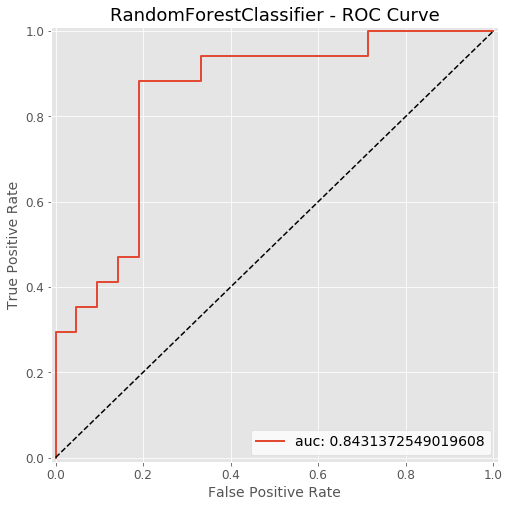

In [86]:
plot_roc_curve(fpr, tpr, auc_rf, rf_clf)

### _Gradient boosting machine model_

In [87]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\gbm_clf_final_round.pk1', 'rb') as f:
    gbm_clf = pickle.load(f)
gbm_clf.fit(data_train_X, data_train['Died'])

GradientBoostingClassifier(max_depth=15, min_samples_leaf=4,
                           min_samples_split=71, n_estimators=151,
                           random_state=42)

Accuracy scores

In [88]:
accu_gbm = accuracy_score(data_test['Died'], gbm_clf.predict(data_test_X))

In [89]:
accu_gbm

0.7894736842105263

In [90]:
pd.crosstab(data_test['Died'], gbm_clf.predict(data_test_X))

col_0,0,1
Died,,
0,16,5
1,3,14


ROC and AUC

In [91]:
pred_proba_gbm = gbm_clf.predict_proba(data_test_X)

In [92]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_gbm[:, 1])
auc_gbm = roc_auc_score(data_test['Died'], pred_proba_gbm[:, 1])

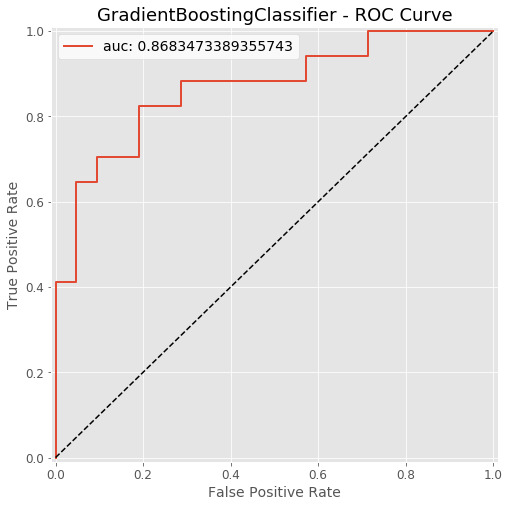

In [93]:
plot_roc_curve(fpr, tpr, auc_gbm, gbm_clf)

### _Support vector machine model_

In [94]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\svc_clf_final_round.pkl', 'rb') as f:
    svc_clf = pickle.load(f)
svc_clf.fit(data_train_X, data_train['Died'])

SVC(C=10, kernel='poly', probability=True, random_state=42)

Accuracy scores

In [95]:
accu_svc = accuracy_score(data_test['Died'], svc_clf.predict(data_test_X))

In [96]:
accu_svc

0.7631578947368421

In [97]:
pd.crosstab(data_test['Died'], svc_clf.predict(data_test_X))

col_0,0,1
Died,,
0,16,5
1,4,13


ROC and AUC

In [98]:
pred_proba_svc = svc_clf.predict_proba(data_test_X)

In [99]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_svc[:, 1])
auc_svc = roc_auc_score(data_test['Died'], pred_proba_svc[:, 1])

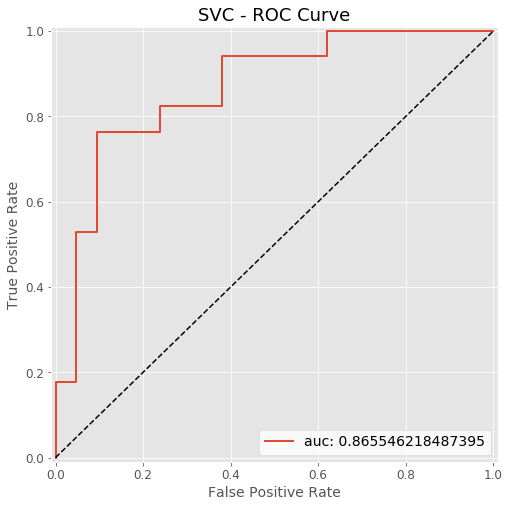

In [100]:
plot_roc_curve(fpr, tpr, auc_svc, svc_clf)

### AdaBoostClassifier classifier
Support vector machine classifier is a powerful classifier that works best on small to medium size complex data set. Our training set is medium size to SVMs.

In [101]:
# Import model and retrain
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\adab_clf_final_round.pk1', 'rb') as f:
    adab_clf = pickle.load(f)
adab_clf.fit(data_train_X, data_train['Died'])

AdaBoostClassifier(learning_rate=1, n_estimators=10, random_state=42)

In [102]:
accu_adab = accuracy_score(data_test['Died'], adab_clf.predict(data_test_X))

In [103]:
accu_adab

0.7631578947368421

In [104]:
pd.crosstab(data_test['Died'], svc_clf.predict(data_test_X))

col_0,0,1
Died,,
0,16,5
1,4,13


In [105]:
pred_proba_adab = adab_clf.predict_proba(data_test_X)

In [106]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_adab[:, 1])
auc_adab = roc_auc_score(data_test['Died'], pred_proba_adab[:, 1])

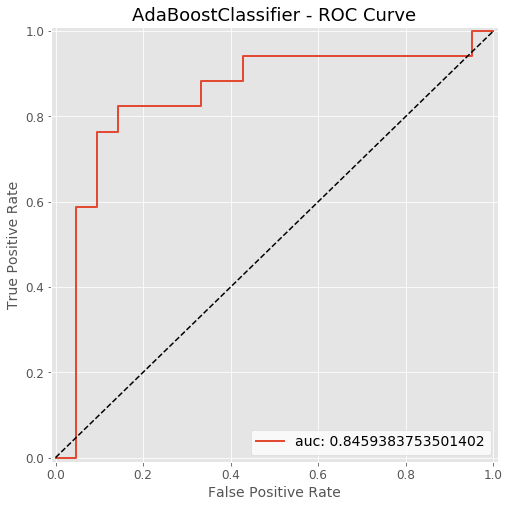

In [107]:
plot_roc_curve(fpr, tpr, auc_adab, adab_clf)

### _The ensemble model_

In [108]:
# Import model and retrain  ensemble_clf_final_round.pkl
with open(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\Models\ensemble_clf_final_round.pkl', 'rb') as f:
    ensemble_clf = pickle.load(f)
ensemble_clf.fit(data_train_X, data_train['Died'])

VotingClassifier(estimators=[('lr', LogisticRegression(C=1, random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=24,
                                                     min_samples_leaf=16,
                                                     min_samples_split=44,
                                                     n_estimators=29,
                                                     random_state=42)),
                             ('gbm',
                              GradientBoostingClassifier(max_depth=15,
                                                         min_samples_leaf=4,
                                                         min_samples_split=71,
                                                         n_estimators=151,
                                                         random_state=42)),
                             ('svc',
                              SVC(C=10, kernel='poly', probability=True,
  

Accuracy scores

In [109]:
accu_ensemble = accuracy_score(data_test['Died'], ensemble_clf.predict(data_test_X))


In [110]:
accu_ensemble

0.8157894736842105

In [111]:
pd.crosstab(data_test['Died'], ensemble_clf.predict(data_test_X))

col_0,0,1
Died,,
0,16,5
1,2,15


ROC and AUC

In [112]:
pred_proba_ensemble = ensemble_clf.predict_proba(data_test_X)

In [113]:
fpr, tpr, _ = roc_curve(data_test['Died'], pred_proba_ensemble[:, 1])
auc_ensemble = roc_auc_score(data_test['Died'], pred_proba_ensemble[:, 1])

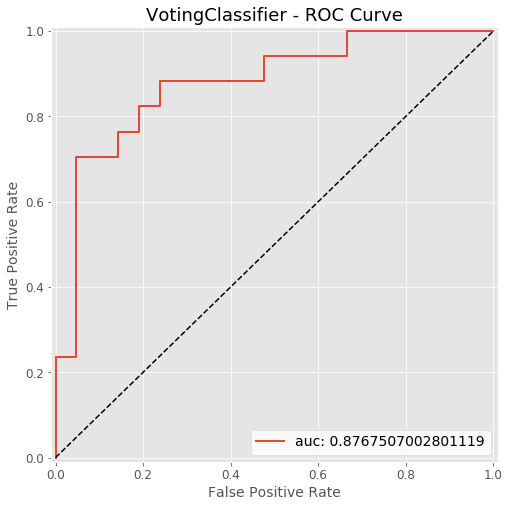

In [114]:
plot_roc_curve(fpr, tpr, auc_ensemble, ensemble_clf)

## 7. Summary
Support vector machine, random forests and gradient boosting classifiers are better than  in predictive performance. All of them achieved an above-77% accuracy(threshold = .5) and above 0.85 in Area Under the ROC Curve with the leading predictor being the gradient boosting machine classifier. The classifiers performed well, but would likely benefit from more training data.

A simple ensemble technique boosts the AUC by .001%, but reduces the accuracy by .001.

## Final Results

In [115]:
pd.DataFrame([[accu_lr, accu_svc, accu_rf, accu_gbm, accu_adab,accu_ensemble],
              [auc_lr, auc_svc, auc_rf, auc_gbm, auc_adab, auc_ensemble]],
              index=['Accuracy(>=.5)', 'Area Under (ROC) Curve'],
              columns=['Logistic Regression', 'Support vector machine', 'Random forests', 'Gradient boosting machine', 'AdaBoostClassifier ','Ensemble'])

,Logistic Regression,Support vector machine,Random forests,Gradient boosting machine,AdaBoostClassifier,Ensemble
Accuracy(>=.5),0.789474,0.763158,0.657895,0.789474,0.763158,0.815789
Area Under (ROC) Curve,0.887955,0.865546,0.843137,0.868347,0.845938,0.876751


### Concat prediction_proba for each model to test set, save test set

In [227]:
data_test['lr_pred_proba'] = pred_proba_lr[:, 1]
data_test['rf_pred_proba'] = pred_proba_rf[:, 1]
data_test['svc_pred_proba'] = pred_proba_svc[:, 1]
data_test['gbm_pred_proba'] = pred_proba_gbm[:, 1]
data_test['adab_pred_proba'] = pred_proba_adab[:, 1]
data_test['ensemble_pred_proba'] = pred_proba_ensemble[:, 1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.

In [342]:
data_test.to_csv(r'C:\Users\neo\Huijie\Code\Predicting CA Mortality\CA_test_set_with_predictions.csv'.format(len(data_train)), index=False)

## Class breakdown per model

In [343]:
def plot_class_breakdown_hist(df, var, var_name, plot_title, xlog=False, ylog=False, **histkwargs):
    df[var][df.Died == 1].hist(alpha=.5, label='Died', color = "red", **histkwargs)
    df[var][df.Died == 0].hist(alpha=.5, label='Survived', color = "green", **histkwargs)
    plt.xlabel(var_name)
    plt.title(plot_title)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    plt.ylim(ymax=10, ymin=0)
    plt.legend()
    plt.savefig(var_name + ' Class Breakdown.png');

In [344]:
plot_class_breakdown_hist(data_test, 'lr_pred_proba', var_name='Logistic Regression Risk of Death', 
                          plot_title='Logistic Regression Class Breakdown', bins=12)

KeyError: 'lr_pred_proba'

In [345]:
plot_class_breakdown_hist(data_test, 'svc_pred_proba', var_name='SVC Risk of Death', 
                          plot_title='SVC Class Breakdown', bins=12)

KeyError: 'svc_pred_proba'

In [346]:
plot_class_breakdown_hist(data_test, 'rf_pred_proba', var_name='Random Forest Risk of Death', 
                          plot_title='Random Forest Class Breakdown', bins=12)

KeyError: 'rf_pred_proba'

In [347]:
plot_class_breakdown_hist(data_test, 'gbm_pred_proba', var_name='GBM Risk of Death', 
                          plot_title='GBM Class Breakdown', bins=12)

KeyError: 'gbm_pred_proba'

In [348]:
plot_class_breakdown_hist(data_test, 'adab_pred_proba', var_name='AdaBoostClassifier', 
                          plot_title='AdaBoostClassifier Class Breakdown', bins=12)

KeyError: 'adab_pred_proba'

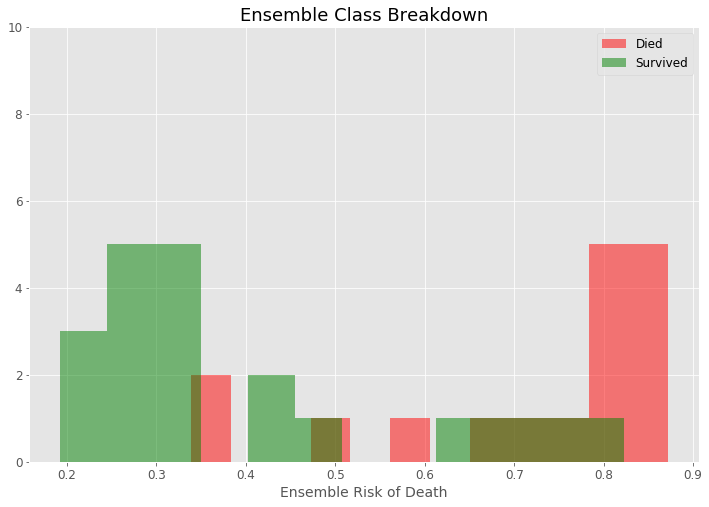

In [235]:
plot_class_breakdown_hist(data_test, 'ensemble_pred_proba', var_name='Ensemble Risk of Death', 
                          plot_title='Ensemble Class Breakdown', bins=12)

In [236]:
import numpy as np
from sklearn import metrics

model = dict()
actual = dict()
predict = dict()
color = dict()
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 6

model[0] = 'Logistic Regression'
actual[0] = data_test.Died
predict[0] = data_test.lr_pred_proba
color[0] = 'blue'

model[1] = 'Support vector machine'
actual[1] = data_test.Died
predict[1] = data_test.svc_pred_proba
color[1] = 'orange'

model[2] = 'Random forests'
actual[2] = data_test.Died
predict[2] = data_test.rf_pred_proba
color[2] = 'green'

model[3] = 'Gradient boosting machine'
actual[3] = data_test.Died
predict[3] = data_test.gbm_pred_proba
color[3] = 'black'

model[4] = 'AdaBoostClassifier'
actual[4] = data_test.Died
predict[4] = data_test.adab_pred_proba
color[4] = 'brown'

model[5] = 'Ensemble'
actual[5] = data_test.Died
predict[5] = data_test.ensemble_pred_proba
color[5] = 'red'

for i in range(n_classes):
    fpr[i], tpr[i], thresholds = metrics.roc_curve(actual[i], predict[i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

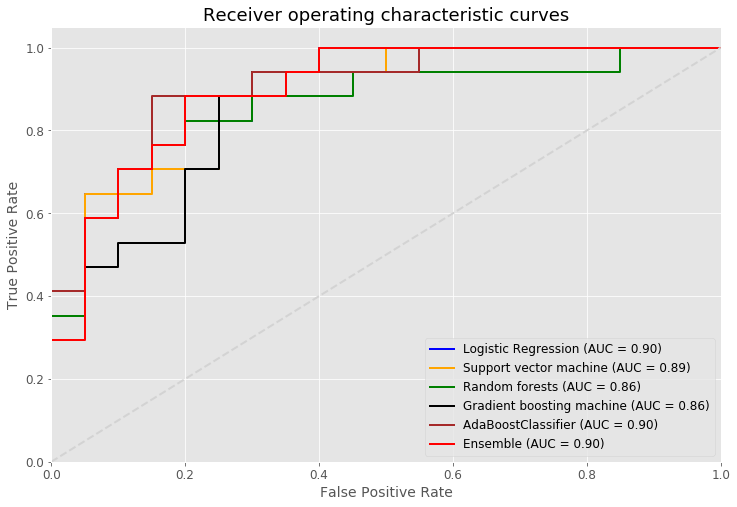

In [237]:
plt.figure()
lw = 2
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=color[i],
         lw=lw, label=model[i]+' (AUC = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='lightgrey', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curves')
plt.legend(loc="lower right")
plt.show()

In [238]:
# observed mortality vs predicted mortality
# end result: Table with column per model (and true score on the end), rows are age groups
# get list of observed mortality per model (per age group find % mortality)
# then get df of all series together (per model create dict where key = model, vals = mortality)
# Create df from dict

#calculate observed mortality
data_test['Died'].sum() / len(data_test['Died'])

# calculate per age group
#age_groups = ['<40','40~65','>=65']
age_groups = ['<12','12~40','40~65','>=65']
predicted_mortality = []
for group in age_groups:
    predicted_mortality.append(data_test[(data_test.Age == group) & (~data_test.Died.isna())]['Died'].sum() 
                               / len(data_test[(data_test.Age == group) & (~data_test.Died.isna())]['Died']))
predicted_mortality

# create list per model
models = ['lr_pred_proba','svc_pred_proba','rf_pred_proba',
          'gbm_pred_proba','adab_pred_proba','ensemble_pred_proba','Died']
predicted_mortality_dict = {}
for model in models:
    mortality_by_age_group = []
    for group in age_groups:
        mortality_by_age_group.append(data_test[(data_test.Age == group) & (~data_test[model].isna())][model].sum() 
                                      / len(data_test[(data_test.Age == group) & (~data_test[model].isna())][model]))
    predicted_mortality_dict[model] = mortality_by_age_group
predicted_mortality_dict

# Create df from dict
observed_mortality_by_agegroup_df = pd.DataFrame.from_dict(predicted_mortality_dict)
# add age_group col
observed_mortality_by_agegroup_df["Age group"] = age_groups
# set age_group col as index
observed_mortality_by_agegroup_df.set_index("Age group", inplace=True)
#re-order columns
observed_mortality_by_agegroup_df = observed_mortality_by_agegroup_df[models]
#Rename columns
observed_mortality_by_agegroup_df.rename(columns={'Died':'True Ratio',
                                                 'lr_pred_proba':'Logistic Regression',
                                                  'svc_pred_proba':'Support Vector Classifier',
                                                  'rf_pred_proba':'Random Forest Classifier',
                                                 'gbm_pred_proba':'Gradient Boosted Machine',
                                                  'adab_pred_proba':'AdaBoostClassifier',
                                                 'ensemble_pred_proba':'Ensemble Classifier'},
                                        inplace=True)
# Rename Index
observed_mortality_by_agegroup_df.rename(index={'<12':'<12',
                                                '12~40':'12~40',
                                               '40~65':'40~65',
                                               '>=65':'>=65'},
                                        inplace=True)
observed_mortality_by_agegroup_df.round(3)

,Logistic Regression,Support Vector Classifier,Random Forest Classifier,Gradient Boosted Machine,AdaBoostClassifier,Ensemble Classifier,True Ratio
Age group,,,,,,,
<12,0.646,0.619,0.609,0.500,0.613,0.597,1.000
12~40,0.441,0.487,0.530,0.391,0.503,0.470,0.250
40~65,0.524,0.521,0.572,0.460,0.520,0.520,0.400
>=65,0.802,0.734,0.596,0.775,0.551,0.692,0.714


In [239]:
# Save output
observed_mortality_by_agegroup_df.to_csv('Observed and Predicted CA by Age Group.csv')
observed_mortality_by_agegroup_df.round(3).to_csv('Observed and Predicted CA by Age Group (Rounded).csv')

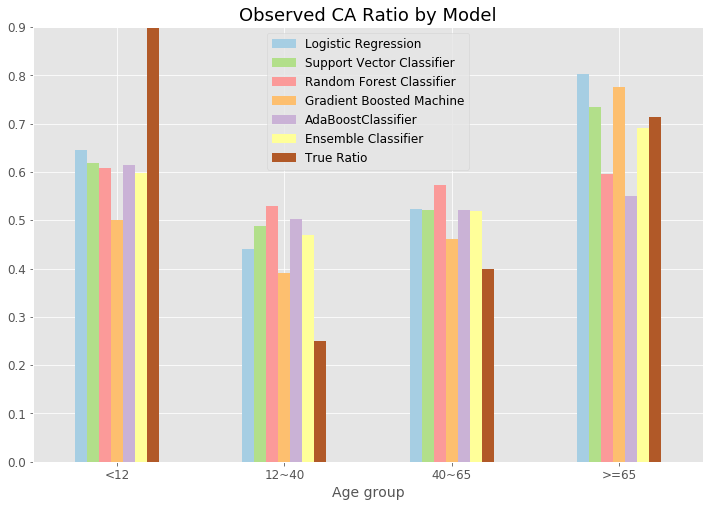

In [240]:
# Create graph
observed_mortality_by_agegroup_df.plot(kind='bar',
                                       ylim=(0,0.9),
                                       rot=0,
                                       title='Observed CA Ratio by Model',
                                       colormap='Paired')

## List of all features used

In [241]:
data_train_X.columns.to_frame().to_csv('Final features for CA_prediction model.csv') # Save to CSV
data_train_X.columns.to_frame()

,0
Gender,Gender
Age,Age
BMI,BMI
Comorbidity_diabetes,Comorbidity_diabetes
Comorbidity_hypertension,Comorbidity_hypertension
Comorbidity_CAD,Comorbidity_CAD
Comorbidity_pulmonary,Comorbidity_pulmonary
Comorbidity_hepatic,Comorbidity_hepatic
Comorbidity_renal,Comorbidity_renal
Comorbidity_neurological,Comorbidity_neurological
